In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
## my functions/classes
from mb_xai import mb_utils
import mb_xai.gut_data as gd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from scipy import stats

def match_Xy_df(X_in_df, y_in_df):
    X_df, y_df = X_in_df.copy(), y_in_df.copy()
    """ Makes sure X_df and y_df have the same indices"""
    overlap = list(set(X_df.index).intersection(set(y_df.index)))
    X_df =  X_df.loc[overlap]
    y_df =  y_df.loc[overlap]
    return X_df, y_df


def get_imp_feature_series(X, n_scores, FEAT_FILTER_TYPE, phenotype, input_type):
    feat_df = pd.DataFrame()

    for est_i in range(len(n_scores["estimator"])):
        if FEAT_FILTER_TYPE == "SelectKBest":
            feat_series_df = pd.Series(n_scores["estimator"][est_i]["logisticregression"].coef_[0], index=X.columns[n_scores["estimator"][est_i][FEAT_FILTER_TYPE.lower()].get_support()],name=est_i)
        elif FEAT_FILTER_TYPE == "RFE":
            feat_series_df = pd.Series(n_scores["estimator"][est_i]["logisticregression"].coef_[0], index=X.columns[n_scores["estimator"][est_i][FEAT_FILTER_TYPE.lower()].support_],name=est_i)
        feat_df = pd.concat([feat_df, feat_series_df],axis=1)

    feat_df.fillna(0, inplace=True)
    feat_df_avg = feat_df.mean(axis=1)
    feat_df_avg.name = phenotype+"_"+input_type
    return feat_df_avg


def drop_constant_cols(df):
    """Get rid of sklearn warnings that say there are constant columns..."""
    df = df.loc[:, (df != df.iloc[0]).any()]
    return df

from collections import Counter

def get_top_df(input_df, col, n_feats=10):
    """
    input_df: imp_feat_flux_pheno_df or imp_feat_abundance_pheno_df
    col: vegan_flux
    """
    top_pos_df = input_df[col].sort_values(ascending=False)[:n_feats][::-1]
    top_neg_df = input_df[col].sort_values(ascending=True)[:n_feats][::-1]
    top_df = pd.DataFrame(pd.concat([top_pos_df, top_neg_df]))
    top_df['positive'] = top_df[col] > 0
    return top_df

def reindex_metab_id2name(in_df, gut_data):
    in_df.index = in_df.index.map(lambda x: gut_data.com_model.metabolites.get_by_id(x).name)
    return in_df

# DATA_LOC = '../../../Data/community_optimization/data/'
DATA_LOC = '../../../Data/microbiome_xai/'
# DATA_LOC = '../../Data/microbiome_xai/'

# FLUX_DF_NAME = "micom_medium-fluxes-top5-736_samples.csv"
FLUX_DF_NAME = "micom_medium-fluxes-top50-9285_samples_fd.csv"

SAVE_FIG = True

gut_data = gd.GutData()
gut_data.load_data(
    # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_50_TOP.pickle',
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_top50_fd.pickle',
    # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
    # FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/SILVA_genus_counts_fd.csv',
    # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
)
### Load flux dataframe
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0, low_memory=False)
X_flux.index = X_flux.index.astype(str)
X_flux = drop_constant_cols(X_flux)

food_matrix_df = pd.read_csv(DATA_LOC+'tables/food_matrix_df_true.csv',index_col=0)
food_matrix_df.index = food_matrix_df.index.map(lambda x: "EX_"+x.replace("[e]", "_m__medium"))

# SAVE_ID = "foodmetabs"
# SAVE_ID = "stdscale"
# SAVE_ID = "stdscale_50feats_c1"#"stdscale", "maxmin" # "minmax"


Fixed EX_tDHNACOA(e)


In [270]:
def get_pvalues(series_df, sig_cutoff=0.05):
    z_scores = stats.zscore(series_df, nan_policy="omit")
    z_scores = z_scores[z_scores.notnull()]
    p_values = stats.norm.sf(abs(z_scores.values))*2 #twosided - onesided *1
    p_values_df = pd.Series(p_values, index=z_scores.index)
    p_values_df_sig = p_values_df[p_values_df<sig_cutoff].sort_values()
    return p_values_df_sig

def get_sigreacts_dict(imp_feat_flux_pheno_df, gut_data, SAMPLE_NUM=10000, SIG_CUTOFF=0.05):
    pheno_sigreacts_dict = {}
    for input_type, input_df in [("flux", imp_feat_flux_pheno_df)]: # "flux", imp_feat_flux_pheno_df_metab
        for i, col in enumerate(input_df.columns):
            trait_input = col#+"_"+input_type
            z_scores = stats.zscore(input_df[trait_input], nan_policy="omit")
            z_scores = z_scores[z_scores.notnull()]
            p_values = stats.norm.sf(abs(z_scores.values))*2 #twosided - onesided *1
            p_values_df = pd.Series(p_values, index=z_scores.index)
            p_values_df_sig = p_values_df[p_values_df<SIG_CUTOFF].sort_values()
            
            if col=="vegan":
                gut_data.set_vegan_df(sample_num=SAMPLE_NUM)
            elif col=="ibs":
                gut_data.set_ibs_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
            elif col=="t2d":
                gut_data.set_t2d_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
            elif col=="ibd":
                gut_data.set_ibd_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
            
            SCALE_TYPE=StandardScaler()
            y_df = gut_data.y_df.copy()
            if input_type=="flux":
                X, y = match_Xy_df(X_flux.copy(), y_df)
            elif input_type=="abundance":
                X, y = match_Xy_df(gut_data.X_df.copy(), y_df)

            # X_scale = SCALE_TYPE.fit_transform(X)
            feat_means_dict = {}
            for feat_id in p_values_df_sig.index:
                col_yes = X.loc[y[y==1].index][feat_id]
                col_no = X.loc[y[y==0].index][feat_id]
                feat_means_dict.update({feat_id: {"yes": col_yes.mean(), "no": col_no.mean()}})
            
            p_values_df_sig = pd.DataFrame(p_values_df_sig)
            p_values_df_sig["yes"] = p_values_df_sig.index.map(lambda x: feat_means_dict[x]["yes"])
            p_values_df_sig["no"] = p_values_df_sig.index.map(lambda x: feat_means_dict[x]["no"])
            pheno_sigreacts_dict.update({trait_input: p_values_df_sig})
            
    return pheno_sigreacts_dict

dict_keys(['vegan_flux', 'ibs_flux', 't2d_flux', 'ibd_flux'])

In [2]:
## Get key columns
exchange_notmedium = []
for react in tqdm(gut_data.com_model.reactions):
    react_id = react.id
    react_name = react.name
    if "EX_" in react_id and "__medium" not in react_id and "medium exchange" not in react_name:
        # print(col)
        exchange_notmedium.append(react_id)
        
exchange_notmedium.append("Unnamed: 0")
exchange_notmedium = list(set(exchange_notmedium)-set(list(['EX_tDHNACOA(e)__lactobacillus'])))
print(len(exchange_notmedium))

100%|██████████| 110071/110071 [00:00<00:00, 973396.46it/s]

15237


In [3]:
## Get smaller set of samples
SAMPLE_NUM = 2000#1000
phenotype = "vegan"
gut_data.norm_abundances(filter_model=False, add_delta=True) ## Filters genus to those in model, adds small value to abundaces
gut_data.X_df = gut_data.asv_df.T.copy()
#print(gut_data.X_df.shape)
#print(gut_data.X_df.iloc[:5,:3])
gut_data.sample_list = gut_data.X_df.index.to_list()

if phenotype=="vegan":
    gut_data.set_vegan_df(sample_num=SAMPLE_NUM)
elif phenotype=="ibs":
    gut_data.set_ibs_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
elif phenotype=="t2d":
    gut_data.set_t2d_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
elif phenotype=="ibd":
    gut_data.set_ibd_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)
    
index_subset = []
for i in gut_data.y_df.index:
    index_subset.append(X_flux.index.get_loc(i)+1)
len(index_subset)

index_subset_skip = set(list(range(len(X_flux.index))))-set(index_subset) - set([0])
len(index_subset_skip)

... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances


7165

In [134]:
gut_data.y_df.index

Index(['10317.000006665', '10317.000084666', '10317.000036066',
       '10317.000053398', '10317.000097225', '10317.000010862',
       '10317.000074640', '10317.000031031', '10317.000076343',
       '10317.000086682',
       ...
       '10317.000079025', '10317.000033232', '10317.000047785',
       '10317.000068061', '10317.000027847', '10317.000047627',
       '10317.000090079', '10317.000097313', '10317.000072584',
       '10317.000005063'],
      dtype='object', name='sample_name', length=1130)

In [4]:
## Takes 49.8s for 50 samples and 15235 columns
## Takes 51.3s for 100 samples and 15235 columns
## Takes 59.7s for 1000 samples and 15235 columns
## Takes 1min 5.5s for 2000 samples and 15235 columns
## DOESNT work for 5000 samples and 15235 columns
FLUX_DF_NAME_all = "micom_fluxes-top50-9285_samples_fd.csv" ## I usually take both

X_flux_notmedium = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME_all,index_col=0, skiprows=index_subset_skip, usecols=exchange_notmedium, low_memory=False) # dtype=np.float64
X_flux_notmedium.index = X_flux_notmedium.index.astype(str)
print(X_flux_notmedium.shape)

(2120, 15236)


In [5]:
X_flux_notmedium.to_csv(gut_data.dir_sim_data+"micom_fluxes-top50-9285_samples_fd_VEGAN-2000.csv")

In [12]:
X_flux_notmedium.std()[X_flux_notmedium.std()>1e-4].sort_values()

EX_taur(e)__dorea                     0.000100
EX_man(e)__subdoligranulum            0.000100
EX_mrphn(e)__faecalibacterium         0.000100
EX_tlf_a_1a(e)__faecalibacterium      0.000100
EX_bilr_355(e)__faecalibacterium      0.000100
                                       ...    
EX_gal(e)__bifidobacterium           76.078180
EX_fru(e)__streptococcus            151.863862
EX_glcur(e)__bifidobacterium        154.983932
EX_h2o(e)__streptococcus            235.475725
EX_h2o(e)__pseudomonas              273.960268
Length: 4793, dtype: float64

In [13]:
X_flux_notmedium.std().loc["EX_tma(e)__streptococcus"]

0.03548654179828053

# Relate fluxes to abundances

In [483]:
# SAVE_ID = "PARALLEL"
# SAVE_ID = "PARALLEL_std_noparams"
# SAVE_ID = "PARALLEL_std-4_noparams_5_75"
SAVE_ID = "PARALLEL_std-4_noparams_5_75"

# input_type_aucs_long = pd.read_csv(gut_data.dir_sim_data+'ml_performance.csv', index_col=0)
# imp_feat_abundance_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_abundance.csv', index_col=0)
# imp_feat_flux_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_flux.csv', index_col=0)
# flux_pheno_direct_df = pd.read_csv(gut_data.dir_sim_data+'imp_flux_direction.csv', index_col=0)

input_type_aucs_long = pd.read_csv(gut_data.dir_sim_data+'ml_performance_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_abundance_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_abundance_%s_fd.csv'%(SAVE_ID), index_col=0)
imp_feat_flux_pheno_df = pd.read_csv(gut_data.dir_sim_data+'imp_feat_flux_%s_fd.csv'%(SAVE_ID), index_col=0)
flux_pheno_direct_df = pd.read_csv(gut_data.dir_sim_data+'imp_flux_direction_%s_fd.csv'%(SAVE_ID), index_col=0)

imp_feat_flux_pheno_df_metab = imp_feat_flux_pheno_df.copy()
imp_feat_flux_pheno_df_metab.index = imp_feat_flux_pheno_df_metab.index.map(lambda x: x.replace("EX_", "").replace("_m__medium", "_m"))
imp_feat_flux_pheno_df_metab["name"] = imp_feat_flux_pheno_df_metab.index.map(lambda x: gut_data.com_model.metabolites.get_by_id(x).name)
imp_feat_flux_pheno_df_metab = reindex_metab_id2name(imp_feat_flux_pheno_df_metab, gut_data)
imp_feat_flux_pheno_df_metab.drop("name",inplace=True,axis=1)
imp_feat_flux_pheno_df_metab.sort_values("vegan_flux",ascending=False)
imp_feat_flux_pheno_df_metab.index = imp_feat_flux_pheno_df_metab.index.map(lambda x: x[:30] if len(x) > 25 else x)
imp_feat_flux_pheno_df_metab

,vegan_flux,ibs_flux,t2d_flux,ibd_flux
"meso-2,6-Diaminoheptanedioate",0.065124,NaN,-0.008713,0.024152
2-Oxobutanoate,0.509887,0.002244,-0.001557,NaN
trans-4-hydroxy-L-proline,-0.057446,-0.013012,0.154383,NaN
acetaldehyde,-0.010783,0.047018,0.012416,0.014430
N-acetyl-D-galactosamine,-0.348098,NaN,0.067135,0.004137
...,...,...,...,...
D-Mannose,NaN,NaN,0.007362,NaN
Urea,NaN,NaN,0.013980,NaN
Adenosine,NaN,NaN,0.003247,NaN
N-acetyl-D-mannosamine,NaN,NaN,0.009001,NaN


In [491]:
pheno_sigreacts_dict = get_sigreacts_dict(
    imp_feat_flux_pheno_df, gut_data, 
    SIG_CUTOFF=0.1, #0.05, 
    SAMPLE_NUM=10000)
# pheno_sigreacts_dict
print(pheno_sigreacts_dict.keys())

dict_keys(['vegan_flux', 'ibs_flux', 't2d_flux', 'ibd_flux'])


In [495]:
map_react2genus = {}
SIG_CUTOFF = 0.1
for input_type, input_df in [("flux", imp_feat_flux_pheno_df)]: # "flux", imp_feat_flux_pheno_df_metab
    #f, ax = plt.subplots(1, len(input_df.columns), figsize=(15, n_feats/2)) # 5 works well for n_feats=10
    for i, col in enumerate(input_df.columns[:1]):
        key_reacts = pheno_sigreacts_dict[col].index
        
        df_pheno = pd.DataFrame()
        for medium_react in key_reacts:
            #medium_react = "EX_tma_m__medium"#"EX_fuc_L_m__medium"
            metab_id = medium_react.replace("EX_","").replace("__medium","")
            react_ids = [x.id for x in gut_data.com_model.metabolites.get_by_id(metab_id).reactions if "medium exchange" not in x.name]
            sig_genus_exchange = get_pvalues(X_flux_notmedium[react_ids].mean().sort_values(), sig_cutoff=SIG_CUTOFF)
            sig_genus_exchange = X_flux_notmedium[react_ids].mean().loc[sig_genus_exchange.index]
            if len(react_ids)<=2:
                sig_genus_exchange = X_flux_notmedium[react_ids].mean()
            sig_genus_exchange.name = medium_react
            sig_genus_exchange.index = sig_genus_exchange.index.map(lambda x: x.split("__")[1])
            
            df_pheno = pd.concat([df_pheno, sig_genus_exchange],axis=1)
            
df_pheno

,EX_tma_m__medium,EX_fuc_L_m__medium,EX_xyluglc_m__medium,EX_ddca_m__medium,EX_indole_m__medium,EX_tlf_a_1b_m__medium
streptococcus,0.013823,NaN,NaN,NaN,NaN,NaN
dysgonomonas,NaN,0.006309,NaN,NaN,NaN,NaN
alistipes,NaN,NaN,NaN,-0.105242,NaN,NaN
akkermansia,NaN,NaN,NaN,NaN,-0.00415,NaN
clostridium,NaN,NaN,NaN,NaN,NaN,0.000305


In [493]:
medium_react = "EX_f1a_m__medium"#
metab_id = medium_react.replace("EX_","").replace("__medium","")
react_ids = [x.id for x in gut_data.com_model.metabolites.get_by_id(metab_id).reactions if "medium exchange" not in x.name]
# sig_genus_exchange = get_pvalues(X_flux_notmedium[react_ids].mean().sort_values())
X_flux_notmedium[react_ids].mean()

EX_f1a(e)__blautia           -0.000080
EX_f1a(e)__akkermansia       -0.000061
EX_f1a(e)__bacteroides       -0.000039
EX_f1a(e)__barnesiella       -0.000084
EX_f1a(e)__bifidobacterium   -0.000062
EX_f1a(e)__lactobacillus     -0.000045
dtype: float64

In [ ]:
medium_react = "EX_sprm_m__medium"#"EX_ind3ppa_m"# "EX_tma_m__medium"#"EX_fuc_L_m__medium"
metab_id = medium_react.replace("EX_","").replace("__medium","")
react_ids = [x.id for x in gut_data.com_model.metabolites.get_by_id(metab_id).reactions if "medium exchange" not in x.name]
print(X_flux_notmedium[react_ids].mean().sort_values())
if len(react_ids)==1:
    print("yes:",X_flux_notmedium[react_ids[0]].loc[gut_data.y_df[gut_data.y_df==1].index].mean())
    print("no:",X_flux_notmedium[react_ids[0]].loc[gut_data.y_df[gut_data.y_df==0].index].mean())
else:
    print("yes:",X_flux_notmedium[react_ids].loc[gut_data.y_df[gut_data.y_df==1].index].mean().sort_values())
    print("no:",X_flux_notmedium[react_ids].loc[gut_data.y_df[gut_data.y_df==0].index].mean().sort_values())

# Network visualization

In [462]:
import networkx as nx

def get_node_colors(imp_feat_flux_pheno_df, imp_feat_abundance_pheno_df, pheno="vegan",cutoff_val = 0.05):
    color_map = []
    node_2color_dict = {}
    for node in G:
        # print(node)
        color_id=None
        for input_type, input_df in [("flux", imp_feat_flux_pheno_df), ("abundance", imp_feat_abundance_pheno_df)]:
            if node in input_df[pheno+"_"+input_type].index:
                if input_df[pheno+"_"+input_type].loc[node]>cutoff_val :
                    color_id = 'skyblue'
                elif input_df[pheno+"_"+input_type].loc[node]<-cutoff_val :
                    color_id = 'lightcoral'
                else:
                    color_id = "grey"
                color_map.append(color_id)
                node_2color_dict.update({node: color_id})
        if color_id==None:
            color_map.append("grey")
            node_2color_dict.update({node: "grey"})
            
    return node_2color_dict, color_map

In [437]:
for key in right_nodes:
    if key not in node_2color_dict.keys():
        print(key)
        
for key in left_nodes:
    if key not in node_2color_dict.keys():
        print(key)

dysgonomonas


{'alistipes': 'lightcoral', 'streptococcus': 'lightcoral', 'clostridium': 'grey', 'dysgonomonas': 'grey', 'akkermansia': 'lightcoral', 'EX_tma_m__medium': 'lightcoral', 'EX_tlf_a_1b_m__medium': 'lightcoral', 'EX_indole_m__medium': 'skyblue', 'EX_fuc_L_m__medium': 'lightcoral', 'EX_ddca_m__medium': 'skyblue'}


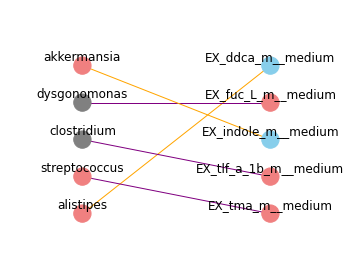

In [496]:
SAVE_FIG = True

f, ax = plt.subplots(1,1,figsize=(5,4))
G = nx.Graph()
left_nodes = list(set(df_pheno.stack().reset_index()["level_0"].values))
right_nodes = list(set(df_pheno.stack().reset_index()["level_1"].values))
max_node_height = max(len(left_nodes), len(right_nodes))
G.add_nodes_from(left_nodes, bipartite=0) # Add the node attribute "bipartite"
G.add_nodes_from(right_nodes, bipartite=1)
# G.add_nodes_from(right_nodes, bipartite=2)
# B.add_edges_from([(1,'a'), (1,'b'), (2,'b'), (2,'c'), (3,'c'), (4,'a')])
# B.add_edges_from(
#     [(idx[0], idx[1]) for idx, row in df_pheno.stack().iteritems()])
G.add_weighted_edges_from(
    [(idx[0], idx[1], row) for idx, row in df_pheno.stack().iteritems()], 
    weight='weight')
# G.add_weighted_edges_from(
#     [(idx[1], idx[0], row) for idx, row in df_pheno.stack().iteritems()], 
#     weight='weight')

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
edge_colors = ["purple" if x >0 else "orange" for x in weights]
# Separate by group
# print(B.edges(data=True))

pos = {node:[0, i-len(left_nodes)/2] for i,node in enumerate(left_nodes)}
pos.update({node:[1, i-len(right_nodes)/2] for i,node in enumerate(right_nodes)})
# pos.update({node:[2, i-len(right_nodes)/2] for i,node in enumerate(left_nodes)})
node_2color_dict, color_map = get_node_colors(
    imp_feat_flux_pheno_df, imp_feat_abundance_pheno_df, pheno="vegan",cutoff_val = 0.2)
print(node_2color_dict)
nx.draw(
    G, pos, with_labels=False, 
    node_color=color_map, 
    edge_color=edge_colors,
    width=1.0,node_size=300, arrows=True)
for p in pos:  # raise text positions
    pos[p][1] += 0.25
    
# for edge in G.edges(data=True):
#     w = edge[2]['weight']
#     nx.draw_networkx_edges(G, pos, edgelist=[(edge[0],edge[1])], arrowsize=100)
# plt.show()
nx.draw_networkx_labels(G, pos)

#plt.tight_layout()
f.tight_layout()
plt.margins(x=0.4,y=0.4)
#plt.show()
if SAVE_FIG == True:
    f.savefig(gut_data.dir_sim_data+"figures/"+"genus_flux_networkx_%s.svg"%(SAVE_ID))
    f.savefig(gut_data.dir_sim_data+"figures/"+"genus_flux_networkx_%s.png"%(SAVE_ID))


In [418]:
X_flux["EX_ind3ppa_m__medium"].std()

3.585604564727233e-07

In [416]:
X_flux["EX_tma_m__medium"].std()

0.007251246841037339

In [411]:
X_flux["EX_ind3ppa_m__medium"].mean()

9.832759487621488e-08

<AxesSubplot:>

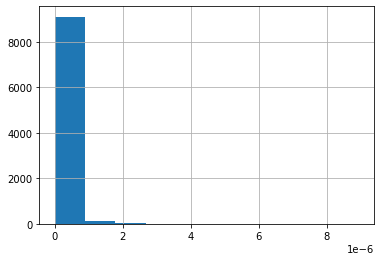

In [414]:
X_flux["EX_ind3ppa_m__medium"].hist()

In [419]:
X_flux["EX_indlac_m__medium"].std()

6.808702529945598e-07

In [354]:
input_df[col].loc[node]>0

2.110458018119921

{'alistipes': 'lightcoral',
 'streptococcus': 'lightcoral',
 'clostridium': 'lightcoral',
 'dysgonomonas': 'grey',
 'bacteroides': 'skyblue',
 'EX_tma_m__medium': 'lightcoral',
 'EX_sprm_m__medium': 'lightcoral',
 'EX_indlac_m__medium': 'lightcoral',
 'EX_gsn_m__medium': 'skyblue',
 'EX_fuc_L_m__medium': 'lightcoral',
 'EX_ddca_m__medium': 'skyblue',
 'EX_ind3ppa_m__medium': 'skyblue'}

In [334]:
max_node_height

7

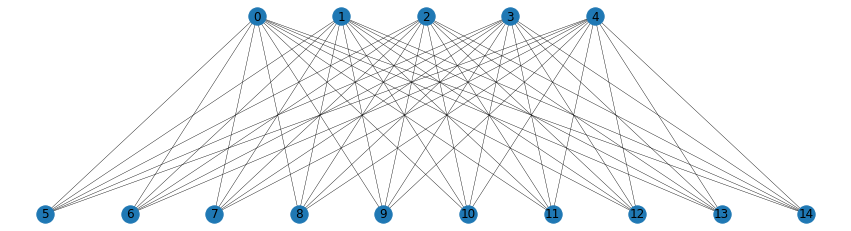

In [339]:
import networkx as nx
import matplotlib.pyplot as plt

m, n = 5, 10
K = nx.complete_bipartite_graph(m, n)
pos = {}
pos.update((i, (i - m/2, 1)) for i in range(m))
pos.update((i, (i - m - n/2, 0)) for i in range(m, m + n))

fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
nx.draw(K, with_labels=True, pos=pos, node_size=300, width=0.4)
plt.show()

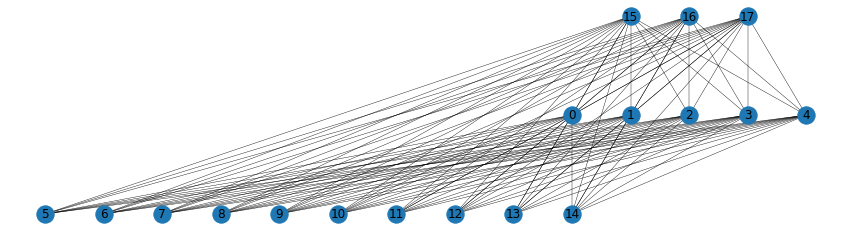

In [323]:
import networkx as nx
import matplotlib.pyplot as plt

m, n, z = 5, 10, 3
K = nx.complete_multipartite_graph(m, n, z)
pos = {}
pos.update((i, (i - m/2, 1)) for i in range(m))
pos.update((i, (i - m -n - z/2, 0)) for i in range(m, m + n))
pos.update((i, (i - m -n- z/2, 2)) for i in range(m + n, m + n+ z))

fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
nx.draw(K, with_labels=True, pos=pos, node_size=300, width=0.4)
plt.show()

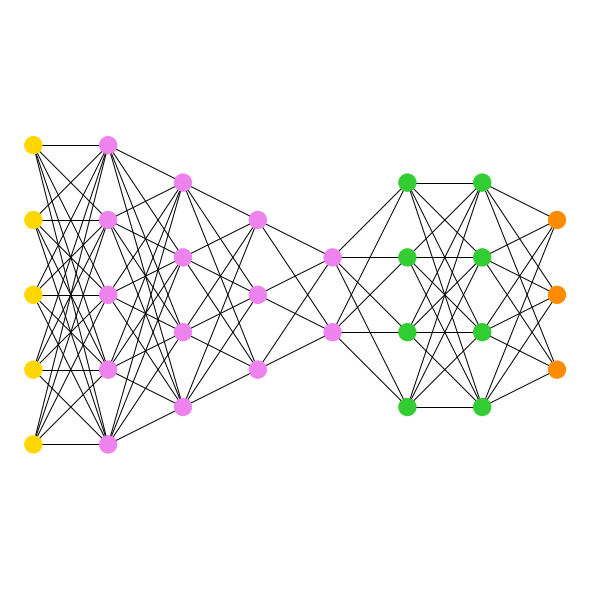

In [324]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx

subset_sizes = [5, 5, 4, 3, 2, 4, 4, 3]
subset_color = [
    "gold",
    "violet",
    "violet",
    "violet",
    "violet",
    "limegreen",
    "limegreen",
    "darkorange",
]


def multilayered_graph(*subset_sizes):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    G = nx.Graph()
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G


G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=False)
plt.axis("equal")
plt.show()

EX_sprm(e)__clostridium    0.00001
dtype: float64
yes: 9.513954675225826e-06
no: 9.630180260619683e-06


In [275]:
gut_data.y_df[gut_data.y_df==1].index

Index([], dtype='object')

In [274]:
X_flux_notmedium[react_ids[0]].loc[gut_data.y_df[gut_data.y_df==1].index]

Series([], Name: EX_sprm(e)__clostridium, dtype: float64)

In [ ]:
gut_data.com_model.reactions.get_by_id("EX_12dgr180_m")

# Connect metabolites to food matrix

In [246]:
food_matrix_df = pd.read_csv(DATA_LOC+'tables/food_matrix_df.csv',index_col=0)
# food_matrix_df = pd.read_csv(DATA_LOC+'tables/food_matrix_df_true.csv',index_col=0)
food_matrix_df.drop(["salcn[e]"], inplace=True)

In [247]:
## Negative means it's consumed and positive means it's leaving the system
X_flux_consumed = X_flux[X_flux.columns[X_flux.mean()<0]].copy()
X_flux_consumed_cols = [x.replace("EX_", "").replace("_m__medium", "[e]") for x in X_flux_consumed.columns]
len(X_flux_consumed_cols)

464

In [248]:
bool_concentrations = True # True
bool_direct_flux = False # False whether to use orig flux df or direction corrected one...
bool_consumption = True
## convert medium flux id to metabolite id used in food matrix

if bool_direct_flux==False:
    imp_feat_flux_pheno_df["id"] = imp_feat_flux_pheno_df.index.map(lambda x: x.replace("EX_", "").replace("_m__medium", "[e]"))
    flux_id_pheno_direct_df = imp_feat_flux_pheno_df.set_index("id")
else:
    flux_pheno_direct_df["id"] = flux_pheno_direct_df.index.map(lambda x: x.replace("EX_", "").replace("_m__medium", "[e]"))
    flux_id_pheno_direct_df = flux_pheno_direct_df.set_index("id")
    
if bool_consumption == True:
    shared_consumed_metabs = list(set(flux_id_pheno_direct_df.index).intersection(set(X_flux_consumed_cols)))
    flux_id_pheno_direct_df = flux_id_pheno_direct_df.loc[shared_consumed_metabs].copy()

flux_id_pheno_direct_df.fillna(0, inplace=True)

## binarize the matrix so 0 describes absence of chemical and 1 describes presence
food_bool_matrix_df = food_matrix_df.copy()
if bool_concentrations==False:
    food_bool_matrix_df[food_bool_matrix_df>0] = 1
food_bool_matrix_df.fillna(0, inplace=True)

## how many important chemicals are found in food matrix?
metab_overlap = list(set(flux_id_pheno_direct_df.index).intersection(set(food_bool_matrix_df.index)))
print(len(metab_overlap))

107


In [249]:
food_signal_df = pd.DataFrame()

y_df = flux_id_pheno_direct_df.loc[metab_overlap].copy()
A_df = food_bool_matrix_df.loc[metab_overlap].copy()

In [251]:
y_df[input_type].sort_values()

id
dad_2[e]     -0.153463
asn_L[e]     -0.127513
12ppd_S[e]   -0.127190
glypro[e]    -0.088654
thymd[e]     -0.079735
                ...   
gthox[e]      0.252107
tre[e]        0.268506
gsn[e]        0.751712
ddca[e]       0.849221
xylt[e]       1.193107
Name: vegan_flux, Length: 107, dtype: float64

In [250]:
input_type = "vegan_flux"
sig_food_metabs = get_pvalues(y_df[input_type].sort_values(), sig_cutoff=0.05)
sig_food_metabs = y_df[input_type].sort_values().loc[sig_food_metabs.index]
sig_food_metabs.name = input_type
# sig_genus_exchange.index = sig_genus_exchange.index.map(lambda x: x.split("__")[1])
sig_food_metabs

id
xylt[e]    1.193107
ddca[e]    0.849221
gsn[e]     0.751712
Name: vegan_flux, dtype: float64

In [212]:
A_df["Owl, horned, flesh, raw (Alaska Native)"].loc[sig_food_metabs.index]

id
xylt[e]       0.0
ddca[e]       1.0
gsn[e]        1.0
tre[e]        0.0
gthox[e]      1.0
dad_2[e]      0.0
cytd[e]       1.0
asn_L[e]      1.0
12ppd_S[e]    0.0
glypro[e]     0.0
thymd[e]      0.0
Name: Owl, horned, flesh, raw (Alaska Native), dtype: float64

In [219]:
A_df["Meats"].loc[sig_food_metabs.index].sort_values()

id
fuc_L[e]        0.0
glyleu[e]       0.0
glu_L[e]        0.0
ttdca[e]        0.0
2hyoxplac[e]    0.0
gchola[e]       0.0
na1[e]          0.0
C02356[e]       0.0
dms[e]          0.0
5aptn[e]        0.0
hista[e]        0.0
gln_L[e]        0.0
M03134[e]       0.0
pheme[e]        0.0
4hpro_LT[e]     0.0
glcr[e]         0.0
dopa[e]         0.0
nh4[e]          0.0
glcur[e]        0.0
ocdca[e]        0.0
tym[e]          0.0
chtbs[e]        0.0
thymd[e]        0.0
dpcoa[e]        0.0
cholate[e]      0.0
glypro[e]       0.0
xylt[e]         0.0
ddca[e]         0.0
gsn[e]          0.0
gal[e]          0.0
tre[e]          0.0
arab_L[e]       0.0
gthox[e]        0.0
cytd[e]         0.0
ser_D[e]        0.0
dad_2[e]        0.0
gly[e]          0.0
pnto_R[e]       0.0
dmso[e]         0.0
asn_L[e]        0.0
12ppd_S[e]      0.0
chor[e]         0.0
oxa[e]          0.0
isomal[e]       0.0
acac[e]         0.0
2mbut[e]        0.0
taur[e]         0.0
ch4s[e]         0.0
sprm[e]         1.0
btn[e]          1

In [208]:
A_df.loc["tre[e]"].sort_values()

Abalone            0.0
Peanut             0.0
Pear               0.0
Pecan nut          0.0
Pectin             0.0
                  ... 
Oyster mushroom    1.0
Garden tomato      1.0
Common mushroom    1.0
Mushrooms          1.0
Bitter gourd       1.0
Name: tre[e], Length: 931, dtype: float64

In [ ]:
sig_genus_exchange = X_flux_notmedium[react_ids].mean().loc[sig_genus_exchange.index]
sig_genus_exchange.name = medium_react
sig_genus_exchange.index = sig_genus_exchange.index.map(lambda x: x.split("__")[1])

In [191]:
y_df["vegan_flux"].sort_values()

id
dad_2[e]     -0.153463
asn_L[e]     -0.127513
12ppd_S[e]   -0.127190
glypro[e]    -0.088654
thymd[e]     -0.079735
                ...   
gthox[e]      0.252107
tre[e]        0.268506
gsn[e]        0.751712
ddca[e]       0.849221
xylt[e]       1.193107
Name: vegan_flux, Length: 107, dtype: float64

In [186]:
imp_feat_flux_pheno_df.loc[df_pheno.columns]

,vegan_flux,ibs_flux,t2d_flux,ibd_flux,id
EX_fuc_L_m__medium,-2.373709,0.019510,-0.004548,NaN,fuc_L[e]
EX_xyluglc_m__medium,-2.239058,0.021901,-0.023439,NaN,xyluglc[e]
EX_ind3ppa_m__medium,2.110458,NaN,-0.092383,0.032415,ind3ppa[e]
EX_indlac_m__medium,-1.435429,NaN,-0.053124,-0.829100,indlac[e]
EX_xylt_m__medium,1.193107,NaN,NaN,NaN,xylt[e]
EX_f1a_m__medium,0.945300,NaN,-0.016720,-0.021123,f1a[e]
EX_ddca_m__medium,0.849221,NaN,0.013434,NaN,ddca[e]
EX_tma_m__medium,-0.827905,NaN,0.003395,NaN,tma[e]
EX_gsn_m__medium,0.751712,NaN,-0.026277,NaN,gsn[e]
EX_gncore1_m__medium,-0.692476,NaN,0.008035,NaN,gncore1[e]


In [175]:
df_pheno_food_overlap = imp_feat_flux_pheno_df.loc[df_pheno.columns][
    imp_feat_flux_pheno_df.loc[df_pheno.columns]["id"].isin(metab_overlap)
].copy()

,vegan_flux,ibs_flux,t2d_flux,ibd_flux,id
EX_fuc_L_m__medium,-2.373709,0.01951,-0.004548,NaN,fuc_L[e]
EX_xylt_m__medium,1.193107,NaN,NaN,NaN,xylt[e]
EX_ddca_m__medium,0.849221,NaN,0.013434,NaN,ddca[e]
EX_gsn_m__medium,0.751712,NaN,-0.026277,NaN,gsn[e]


In [180]:
A_df.loc["gsn[e]"].sort_values()

Liquorice             0.0000
Morchella (Morel)     0.0000
Mountain hare         0.0000
Multigrain bread      0.0000
Mundu                 0.0000
                      ...   
Nutmeg                1.0000
Cloudberry            1.0000
Nectarine             1.0000
Abalone               1.0000
Beer                 53.9224
Name: gsn[e], Length: 931, dtype: float64

In [177]:
A_df.loc["fuc_L[e]"].sort_values()

Abalone                    0.000000
Peanut                     0.000000
Pear                       0.000000
Pecan nut                  0.000000
Pectin                     0.000000
                            ...    
Potato                     1.000000
Milk and milk products     1.000000
Caraway                    1.000000
Corn                       1.000000
Milk (Cow)                26.016364
Name: fuc_L[e], Length: 931, dtype: float64

In [104]:
X_flux_notmedium[react_ids].mean()

EX_gncore1(e)__barnesiella       -0.000050
EX_gncore1(e)__bacteroides       -0.000047
EX_gncore1(e)__akkermansia       -0.000050
EX_gncore1(e)__blautia           -0.000075
EX_gncore1(e)__bifidobacterium   -0.000063
EX_gncore1(e)__lactobacillus     -0.000035
dtype: float64

In [59]:
imp_feat_flux_pheno_df["vegan_flux"].sort_values()

EX_fuc_L_m__medium          -2.373709
EX_xyluglc_m__medium        -2.239058
EX_indlac_m__medium         -1.435429
EX_tma_m__medium            -0.827905
EX_gncore1_m__medium        -0.692476
                               ...   
EX_lactl_m__medium                NaN
EX_4hbz_m__medium                 NaN
EX_pullulan1200_m__medium         NaN
EX_nchlphncl_m__medium            NaN
EX_galactan_m__medium             NaN
Name: vegan_flux, Length: 474, dtype: float64

In [64]:
gut_data.com_model.reactions.get_by_id("EX_fuc_L_m").metabolites

{<Metabolite fuc_L_m at 0x7f2806c60ac0>: -1}

In [264]:
medium_react = "EX_sprm_m__medium"#"EX_ind3ppa_m"# "EX_tma_m__medium"#"EX_fuc_L_m__medium"
metab_id = medium_react.replace("EX_","").replace("__medium","")
react_ids = [x.id for x in gut_data.com_model.metabolites.get_by_id(metab_id).reactions if "medium exchange" not in x.name]
print(X_flux_notmedium[react_ids].mean().sort_values())
if len(react_ids)==1:
    print("yes:",X_flux_notmedium[react_ids[0]].loc[gut_data.y_df[gut_data.y_df==1].index].mean())
    print("no:",X_flux_notmedium[react_ids[0]].loc[gut_data.y_df[gut_data.y_df==0].index].mean())
else:
    print("yes:",X_flux_notmedium[react_ids].loc[gut_data.y_df[gut_data.y_df==1].index].mean().sort_values())
    print("no:",X_flux_notmedium[react_ids].loc[gut_data.y_df[gut_data.y_df==0].index].mean().sort_values())

EX_sprm(e)__clostridium    0.00001
dtype: float64
yes: 9.513954675225826e-06
no: 9.630180260619683e-06


In [261]:
X_flux_notmedium[react_ids].loc[gut_data.y_df[gut_data.y_df==1].index]

,EX_sprm(e)__clostridium
sample_name,
10317.000023593,0.000004
10317.000072316,0.000001
10317.000052024,0.000010
10317.000092868,0.000002
10317.000053337,0.000009
...,...
10317.000089225,0.000028
10317.000090512,0.000012
10317.000097101,0.000029


In [258]:
gut_data.y_df[gut_data.y_df==1]

""


In [163]:
gut_data.com_model.metabolites.get_by_id("ind3ppa_m")

Metabolite identifier,ind3ppa_m
Name,Indole-3-propionate
Memory address,0x07f28033602e0
Formula,C11H10NO2
Compartment,m
In 2 reaction(s),"EX_ind3ppa(e)__clostridium, EX_ind3ppa_m"


In [128]:
X_flux_notmedium

,EX_12dgr180(e)__acinetobacter,EX_26dap_M(e)__acinetobacter,EX_2dmmq8(e)__acinetobacter,EX_2hyoxplac(e)__acinetobacter,EX_34dhpha(e)__acinetobacter,EX_34dhphe(e)__acinetobacter,EX_3hcinnm(e)__acinetobacter,EX_3hphac(e)__acinetobacter,EX_3hpppn(e)__acinetobacter,EX_3mop(e)__acinetobacter,...,EX_taur(e)__finegoldia,EX_thm(e)__finegoldia,EX_thr_L(e)__finegoldia,EX_tre(e)__finegoldia,EX_trp_L(e)__finegoldia,EX_tyr_L(e)__finegoldia,EX_ura(e)__finegoldia,EX_val_L(e)__finegoldia,EX_xan(e)__finegoldia,EX_zn2(e)__finegoldia
10317.000047251,-0.000450,-0.000168,-0.000008,0.000009,-0.000031,-0.000082,-0.000010,-0.000013,-0.000009,-0.003615,...,0.0,-0.000003,-0.000419,0.0,-0.000045,-0.000102,-1.682451e-06,-0.000336,-5.344273e-06,-0.000003
10317.000023086,-0.000796,-0.000228,-0.000002,0.000001,-0.000004,-0.000013,-0.000001,-0.000002,-0.000001,-0.007763,...,0.0,-0.000023,-0.001590,0.0,-0.000351,-0.000895,-5.982225e-07,-0.002618,-8.138484e-07,-0.000023
10317.000052261,-0.000358,-0.000173,-0.000010,0.000014,-0.000047,-0.000119,-0.000016,-0.000020,-0.000014,-0.002560,...,0.0,-0.000003,-0.000563,0.0,-0.000050,-0.000109,-4.517304e-06,-0.000376,-7.557106e-06,-0.000003
10317.000068076,-0.000670,-0.000228,-0.000009,0.000009,-0.000032,-0.000086,-0.000010,-0.000013,-0.000009,-0.005855,...,0.0,-0.000003,-0.000389,0.0,-0.000038,-0.000085,-2.865490e-06,-0.000286,-4.931693e-06,-0.000003
10317.000010808,-0.000245,-0.000495,-0.000046,0.000076,-0.000219,-0.000515,-0.000080,-0.000101,-0.000072,-0.001775,...,0.0,-0.000003,-0.001593,0.0,-0.000040,-0.000012,-2.262592e-05,-0.000300,-3.255235e-05,-0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10317.000068135,-0.000281,-0.000106,-0.000005,0.000006,-0.000019,-0.000051,-0.000006,-0.000008,-0.000006,-0.002337,...,0.0,-0.000016,-0.001238,0.0,-0.000251,-0.000633,-1.871741e-06,-0.001872,-3.554772e-06,-0.000016
10317.000005825,-0.000396,-0.000171,-0.000010,0.000013,-0.000039,-0.000107,-0.000015,-0.000019,-0.000013,-0.002880,...,0.0,-0.000038,-0.002848,0.0,-0.000576,-0.001455,-4.622175e-06,-0.004303,-8.093231e-06,-0.000038
10317.000023755,-0.000389,-0.000121,-0.000003,0.000002,-0.000010,-0.000026,-0.000003,-0.000004,-0.000003,-0.003643,...,0.0,-0.000004,-0.000308,0.0,-0.000054,-0.000134,-4.928809e-07,-0.000405,-1.658958e-06,-0.000004
10317.000047572,-0.000331,-0.000191,-0.000013,0.000019,-0.000054,-0.000145,-0.000021,-0.000027,-0.000019,-0.002068,...,0.0,-0.000003,-0.000578,0.0,-0.000041,-0.000078,-8.639590e-06,-0.000304,-9.674748e-06,-0.000003


In [140]:
X_flux_notmedium#.loc['10317.000033723']

,EX_12dgr180(e)__acinetobacter,EX_26dap_M(e)__acinetobacter,EX_2dmmq8(e)__acinetobacter,EX_2hyoxplac(e)__acinetobacter,EX_34dhpha(e)__acinetobacter,EX_34dhphe(e)__acinetobacter,EX_3hcinnm(e)__acinetobacter,EX_3hphac(e)__acinetobacter,EX_3hpppn(e)__acinetobacter,EX_3mop(e)__acinetobacter,...,EX_taur(e)__finegoldia,EX_thm(e)__finegoldia,EX_thr_L(e)__finegoldia,EX_tre(e)__finegoldia,EX_trp_L(e)__finegoldia,EX_tyr_L(e)__finegoldia,EX_ura(e)__finegoldia,EX_val_L(e)__finegoldia,EX_xan(e)__finegoldia,EX_zn2(e)__finegoldia
10317.000023086,-0.000796,-0.000228,-0.000002,0.000001,-0.000004,-0.000013,-0.000001,-0.000002,-0.000001,-0.007763,...,0.0,-0.000023,-0.001590,0.0,-0.000351,-0.000895,-5.982225e-07,-0.002618,-8.138484e-07,-0.000023
10317.000076488,-0.000300,-0.000359,-0.000031,0.000049,-0.000132,-0.000333,-0.000052,-0.000066,-0.000047,-0.001947,...,0.0,-0.000004,-0.001282,0.0,-0.000055,-0.000075,-1.515727e-05,-0.000407,-2.258530e-05,-0.000004
10317.000089353,-0.000323,-0.000132,-0.000006,0.000008,-0.000028,-0.000072,-0.000009,-0.000012,-0.000008,-0.002476,...,0.0,-0.000002,-0.000351,0.0,-0.000035,-0.000077,-2.614456e-06,-0.000260,-4.449526e-06,-0.000002
10317.000023982,-0.000498,-0.000145,-0.000002,0.000001,-0.000005,-0.000013,-0.000002,-0.000002,-0.000001,-0.004798,...,0.0,-0.000003,-0.000223,0.0,-0.000041,-0.000103,-4.458965e-07,-0.000306,-7.924422e-07,-0.000003
10317.000067746,-0.000205,-0.000150,-0.000011,0.000016,-0.000050,-0.000121,-0.000018,-0.000022,-0.000016,-0.001285,...,0.0,-0.000003,-0.000575,0.0,-0.000045,-0.000092,-5.080707e-06,-0.000336,-8.294284e-06,-0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10317.000072111,-0.404883,-0.021334,-0.000017,0.000005,-0.000100,-26.979545,-0.000004,-0.000008,-0.000004,-3.996962,...,0.0,-0.000002,-0.000254,0.0,-0.000034,-0.000081,-1.666710e-06,-0.000254,-2.175073e-06,-0.000002
10317.000005825,-0.000396,-0.000171,-0.000010,0.000013,-0.000039,-0.000107,-0.000015,-0.000019,-0.000013,-0.002880,...,0.0,-0.000038,-0.002848,0.0,-0.000576,-0.001455,-4.622175e-06,-0.004303,-8.093231e-06,-0.000038
10317.000023755,-0.000389,-0.000121,-0.000003,0.000002,-0.000010,-0.000026,-0.000003,-0.000004,-0.000003,-0.003643,...,0.0,-0.000004,-0.000308,0.0,-0.000054,-0.000134,-4.928809e-07,-0.000405,-1.658958e-06,-0.000004
10317.000047572,-0.000331,-0.000191,-0.000013,0.000019,-0.000054,-0.000145,-0.000021,-0.000027,-0.000019,-0.002068,...,0.0,-0.000003,-0.000578,0.0,-0.000041,-0.000078,-8.639590e-06,-0.000304,-9.674748e-06,-0.000003


In [147]:
gut_data.y_df.index.get_loc("10317.000049934")

390

In [145]:
gut_data.y_df.loc["10317.000023086"]

0

In [144]:
gut_data.y_df.loc["10317.000006665"]

0

EX_ind3ppa(e)__clostridium    0.000025
dtype: float64
EX_ind3ppa(e)__clostridium    0.000025
dtype: float64


In [151]:
X_flux_notmedium[react_ids]

,EX_ind3ppa(e)__clostridium
10317.000023086,0.000001
10317.000076488,0.000090
10317.000089353,0.000015
10317.000023982,0.000002
10317.000067746,0.000031
...,...
10317.000072111,0.000007
10317.000005825,0.000026
10317.000023755,0.000005
10317.000047572,0.000036


In [149]:
X_flux_notmedium[react_ids].loc[gut_data.y_df[gut_data.y_df==0].index].mean().sort_values()

EX_ind3ppa(e)__clostridium    0.000025
dtype: float64

In [93]:
test = get_pvalues(X_flux_notmedium[react_ids].mean().sort_values(), sig_cutoff=0.05)
test.name ="tmao"

test2 = get_pvalues(X_flux_notmedium[react_ids].mean().sort_values(), sig_cutoff=0.05)
test2.name ="ret"

In [96]:
pd.concat([test, test2],axis=1)

,tmao,ret
EX_tma(e)__streptococcus,0.00329,0.00329


<AxesSubplot:>

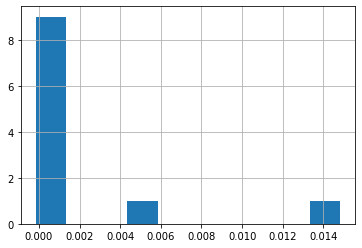

In [78]:
X_flux_notmedium[react_ids].mean().sort_values().hist()

EX_fuc_L(e)__blautia           -0.000034
EX_fuc_L(e)__subdoligranulum   -0.000024
EX_fuc_L(e)__bifidobacterium   -0.000021
EX_fuc_L(e)__roseburia         -0.000019
EX_fuc_L(e)__akkermansia       -0.000016
EX_fuc_L(e)__bacteroides        0.000005
EX_fuc_L(e)__clostridium        0.000129
EX_fuc_L(e)__ruminococcus       0.003453
EX_fuc_L(e)__dysgonomonas       0.008912
dtype: float64

In [73]:
gut_data.com_model.reactions.get_by_id("EX_fuc_L(e)__ruminococcus")

Reaction identifier,EX_fuc_L(e)__ruminococcus
Name,L-Fucose exchange
Memory address,0x07f289ed2a8b0
Stoichiometry,fuc_L[e]__ruminococcus <=> 0.02 fuc_L_m L-fucose <=> 0.02 L-fucose
GPR,
Lower bound,-100
Upper bound,1000.0


Testing

In [46]:
FLUX_DF_NAME = "micom_fluxes-top5-112_samples.csv" ## I usually take both
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME, low_memory=False) #,index_col=0,# dtype=np.float64
X_flux.index = X_flux.index.astype(str)

exchange_notmedium = []
for col in X_flux.columns:
    if "EX_" in col: #and "__medium" not in col:
        # print(col)
        exchange_notmedium.append(col)
        
print(len(exchange_notmedium))
X_flux_exnotmedium = X_flux[exchange_notmedium].copy()
X_flux_exnotmedium.head()

2507


,EX_12dgr180(e)__alistipes,EX_12ppd_S(e)__alistipes,EX_1hibup_S(e)__alistipes,EX_1hibupglu_S(e)__alistipes,EX_1hmdgluc(e)__alistipes,EX_1ohmdz(e)__alistipes,EX_26dap_M(e)__alistipes,EX_2dmmq8(e)__alistipes,EX_2hatvacid(e)__alistipes,EX_2hatvacidgluc(e)__alistipes,...,EX_turan_D_m__medium,EX_tym_m__medium,EX_tyr_L_m__medium,EX_ura_m__medium,EX_urea_m__medium,EX_uri_m__medium,EX_val_L_m__medium,EX_xan_m__medium,EX_xyl_D_m__medium,EX_zn2_m__medium
0,-0.0,5.066955e-12,2.114557e-11,-2.128431e-11,-1.086020e-11,1.091825e-11,-0.013169,-1.665077e-11,2.114557e-11,-2.128431e-11,...,-8.018631e-13,8.814816e-13,-0.509888,0.008094,6.035339e-12,-0.019953,-1.482501,-2.227377e-12,-4.459511e-12,-0.014809
1,-0.0,1.181440e-10,8.838072e-10,-8.856148e-10,-3.462066e-10,3.486762e-10,-0.030108,7.724415e-10,8.838072e-10,-8.856148e-10,...,-2.208605e-12,3.456049e-11,-0.891868,0.007363,1.167319e-09,-0.412539,-4.451335,-9.836946e-11,-1.618280e-10,-0.113833
2,-0.0,2.703472e-10,1.117647e-09,-1.118439e-09,-6.190896e-10,6.396996e-10,-0.000827,-1.649486e-09,1.117647e-09,-1.118439e-09,...,-1.978816e-10,-2.950274e-11,-1.461781,0.000395,3.365445e-10,-0.000361,-6.073277,-1.928214e-10,-3.667772e-10,-0.053401
3,-0.0,5.473050e-11,2.621258e-10,-2.620794e-10,-1.169680e-10,1.169447e-10,-0.113614,-2.241270e-10,2.621258e-10,-2.620794e-10,...,-1.359552e-14,1.014157e-12,-1.297610,81.049766,7.055233e-12,-78.363693,-3.781584,-2.413053e-12,-3.756414e-12,-0.035023
4,-0.0,2.437638e-10,1.778717e-09,-1.768271e-09,-6.872326e-10,6.540827e-10,-0.022510,-7.707406e-10,1.778717e-09,-1.768271e-09,...,-3.608401e-13,-1.049029e-11,-0.593652,0.016123,2.075416e-09,-0.294249,-2.984208,-1.714142e-10,-2.780362e-10,-0.076833


In [47]:
FLUX_DF_NAME = "micom_fluxes-top5-112_samples.csv" ## I usually take both
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,low_memory=False) #index_col=0,  dtype=np.float64
X_flux.index = X_flux.index.astype(str)

In [48]:
X_flux

,Unnamed: 0,12DGR180tex__alistipes,12DGR180tipp__alistipes,12PPD_Stex__alistipes,12PPDtpp__alistipes,1HIBUPGLU_St2pp__alistipes,1HIBUPGLU_Stex__alistipes,1HIBUP_S_GLCAASE__alistipes,1HIBUP_S_GLCAASEepp__alistipes,1HIBUP_Stepp__alistipes,...,EX_turan_D_m__medium,EX_tym_m__medium,EX_tyr_L_m__medium,EX_ura_m__medium,EX_urea_m__medium,EX_uri_m__medium,EX_val_L_m__medium,EX_xan_m__medium,EX_xyl_D_m__medium,EX_zn2_m__medium
0,10317.000001419,0.0,0.0,-5.066955e-12,-5.066955e-12,6.453009e-12,2.095553e-11,6.453009e-12,1.547207e-11,6.453009e-12,...,-8.018631e-13,8.814816e-13,-0.509888,0.008094,6.035339e-12,-0.019953,-1.482501,-2.227377e-12,-4.459511e-12,-0.014809
1,10317.000001960,0.0,0.0,-1.181440e-10,-1.181440e-10,3.097581e-10,8.785663e-10,3.097581e-10,5.793422e-10,3.097581e-10,...,-2.208605e-12,3.456049e-11,-0.891868,0.007363,1.167319e-09,-0.412539,-4.451335,-9.836946e-11,-1.618280e-10,-0.113833
2,10317.000002342,0.0,0.0,-2.703472e-10,-2.703472e-10,3.323513e-10,1.106297e-09,3.323513e-10,7.635001e-10,3.323513e-10,...,-1.978816e-10,-2.950274e-11,-1.461781,0.000395,3.365445e-10,-0.000361,-6.073277,-1.928214e-10,-3.667772e-10,-0.053401
3,10317.000002244,0.0,0.0,-5.473050e-11,-5.473050e-11,7.249461e-11,2.591785e-10,7.249461e-11,1.948543e-10,7.249461e-11,...,-1.359552e-14,1.014157e-12,-1.297610,81.049766,7.055233e-12,-78.363693,-3.781584,-2.413053e-12,-3.756414e-12,-0.035023
4,10317.000003086,0.0,0.0,-2.437638e-10,-2.437638e-10,6.181020e-10,1.765273e-09,6.181020e-10,1.165556e-09,6.181020e-10,...,-3.608401e-13,-1.049029e-11,-0.593652,0.016123,2.075416e-09,-0.294249,-2.984208,-1.714142e-10,-2.780362e-10,-0.076833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,10317.000001833,0.0,0.0,-6.780366e-11,-6.780366e-11,1.847525e-10,5.545275e-10,1.847525e-10,3.477619e-10,1.847525e-10,...,-7.880918e-13,1.227892e-12,-0.413393,1.007595,2.143023e-10,-1.375927,-1.881860,-2.338438e-11,-3.576600e-11,-0.040159
108,10317.000003130,0.0,0.0,-3.458126e-11,-3.458126e-11,4.224049e-11,1.392393e-10,4.224049e-11,9.763008e-11,4.224049e-11,...,-4.185037e-12,1.649147e-11,-0.718421,0.000279,1.223078e-10,-0.212712,-2.283407,-3.323954e-11,-3.765676e-11,-0.040471
109,10317.000001832,0.0,0.0,-2.940758e-11,-2.940758e-11,8.195040e-11,2.396503e-10,8.195040e-11,1.563168e-10,8.195040e-11,...,-1.766493e-14,7.201782e-14,-0.350118,0.248818,1.672425e-10,-0.477069,-1.908104,-1.480192e-11,-2.301539e-11,-0.047271
110,10317.000001435,0.0,0.0,-5.211641e-11,-5.211641e-11,1.289167e-10,3.628541e-10,1.289167e-10,2.450227e-10,1.289167e-10,...,-1.138275e-13,3.609628e-12,-0.549331,0.045069,3.598984e-10,-0.356022,-3.106421,-3.542804e-11,-6.258486e-11,-0.079777
